# Pre-RA Flow PT1: Cell type level subclustering

## Setup

In [1]:
import scyan as sy
import os
import glob
import anndata
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scanpy as sc
import scanpy.external as sce

print(sy.__version__)
print(anndata.__version__)


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


1.5.1
0.10.6


In [2]:
#### ==== parameter set up ==== ####
# define the working path
panel = "PT1"
data_path='/home/jupyter/projects/pre-ra/flow/raw-data/' + panel + '/labelled-expr/cache/'
fig_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/results/' + panel + '_celltype_subsample'  + "/"
proj_name = 'pre-ra_flow_clustering_' + panel
output_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/data/' +panel + '/'

if not os.path.exists(fig_path): os.makedirs(fig_path)
    
if not os.path.exists(output_path): os.makedirs(output_path)

# define scanpy verbose levels
sc.settings.verbosity = 3
sc.settings.figdir = fig_path
sc.settings.n_jobs = -1

## Functions

In [95]:
def subset_anndata_by_cell_types(anndata_obj, cell_types):
    """
    Subset Anndata object by specific cell types from the metadata column "labels".

    Parameters:
        anndata_obj (anndata.AnnData): Anndata object containing single-cell genomics data.
        cell_types (list): List of cell types to subset.

    Returns:
        dict: Dictionary containing cell types as keys and corresponding Anndata objects as values.
    """
    split_anndata = {}
    for cell_type in cell_types:
        subset_indices = anndata_obj.obs['l1_labels'] == cell_type
        subset_anndata = anndata_obj[subset_indices].copy()
        split_anndata[cell_type] = subset_anndata
    return split_anndata

In [142]:
def subsample_adata_by_group(anndata_obj, target_cells,cluster_key ):
    """
    Subsample Anndata object by specific groupings from the metadata columns by fix target cells.

    Parameters:
        anndata_obj (anndata.AnnData): Anndata object containing single-cell genomics data.
        cluster_key (list): List of cell groupings from metadata
        target_cells (num): an integer of the fixed targeted number of cells per groupings

    Returns:
        Anndata object
    """
    grouped = anndata_obj.obs.groupby(cluster_key)

    downsampled_indices = []
    for _, group in grouped:
        if len(group) > target_cells:
            downsampled_indices.extend(group.sample(target_cells).index)
        else:
            downsampled_indices.extend(group.index)
        
    adata_downsampled = adata_sub_celltype[downsampled_indices]
    return(adata_downsampled)

In [201]:
def save_anndata_list(anndata_list, filenames):
    """
    Save a list of Anndata objects to separate H5AD files.

    Parameters:
        anndata_list (list): List of Anndata objects to be saved.
        filenames (list): List of filenames to save Anndata objects.

    Returns:
        None
    """
    # zip() combines two lists into a single tuple
    for anndata_obj, filename in zip(adata_downsampled_celltypes, filenames):
        print(adata_downsampled_celltypes[anndata_obj])
        adata_downsampled_celltypes[anndata_obj].write_h5ad(filename)

In [207]:
def read_anndata_files(file_tuples):
    """
    Read Anndata objects from H5AD files and store them in a dictionary with custom names.

    Parameters:
        file_tuples (list of tuples): List of tuples where each tuple contains filename and desired name.

    Returns:
        dict: Dictionary containing Anndata objects with custom names.
    """
    anndata_dict = {}
    for filename, name in file_tuples:
        anndata_obj = anndata.read_h5ad(filename)
        anndata_dict[name] = anndata_obj
    return anndata_dict

## Read in data 

In [14]:
print("READING IN ADATA")
adata = sc.read_h5ad(output_path + "adata_preprocess_unscaled_" + panel + ".h5ad")
print(adata)

READING IN ADATA
AnnData object with n_obs × n_vars = 54669798 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels'


In [4]:
cell_labels_to_subset_list = adata.obs['l1_labels'].unique()
print(cell_labels_to_subset_list)

['total_t_cells', 'total_nk_cells', 'unknown', 'b_cells', 'debris', 'myeloid_cells', 'Other cells']
Categories (7, object): ['Other cells', 'b_cells', 'debris', 'myeloid_cells', 'total_nk_cells', 'total_t_cells', 'unknown']


In [5]:
print(pd.crosstab(adata.obs['sample_id'], adata.obs['l1_labels'], margins=True)) 


l1_labels   Other cells  b_cells  debris  myeloid_cells  total_nk_cells  \
sample_id                                                                 
PB00055-02          339    38607    5883          11475           17540   
PB00056-02          224    28670    5111          34415           38902   
PB00057-02          169    20663    2385          16258           21568   
PB00058-03           56    10053    2176          36868           20665   
PB00060-03          235    20684    2902          14808           26300   
...                 ...      ...     ...            ...             ...   
PB04906-00          702    89007    6816          41790           86514   
PB04924-00          107    17441    2127          29813           22233   
PB04933-00          381    83436   24843          72642           26766   
PB04937-00          267    60069   13158          14160          145650   
All               38268  4057472  779513        6060299         5333506   

l1_labels   total_t_cell

In [6]:
print(pd.crosstab(adata.obs['l1_labels'], adata.obs['panel'], margins=True)) 


panel                PT1       All
l1_labels                         
Other cells        38268     38268
b_cells          4057472   4057472
debris            779513    779513
myeloid_cells    6060299   6060299
total_nk_cells   5333506   5333506
total_t_cells   32140287  32140287
unknown          6260453   6260453
All             54669798  54669798


In [7]:
### read in metadata 
meta = pd.read_csv("/home/jupyter/projects/pre-ra/flow/raw-data/2023-11-22_ALTRA_Metadata_labs_long-model-vars.csv")

In [8]:
meta["sample.sampleKitGuid"]

0      KT00052
1      KT00055
2      KT00056
3      KT00057
4      KT00058
        ...   
152    KT04924
153    KT04933
154    KT04937
155    KT02968
156    KT04906
Name: sample.sampleKitGuid, Length: 157, dtype: object

In [9]:
meta = meta[[ 'sample.sampleKitGuid','Status_Xsec','Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv','bmi_conv','Age2023']]

In [10]:
meta.head()

,sample.sampleKitGuid,Status_Xsec,Status_Long,subject.biologicalSex,subject.subjectGuid,days_to_conversion,age_conv,bmi_conv,Age2023
0,KT00052,at_risk,pre,Female,CU1009,-714.0,58.0,25.648918,60
1,KT00055,early_RA,NaN,Female,CU1008,NaN,NaN,NaN,57
2,KT00056,at_risk,pre,Female,CU1007,-632.0,44.0,26.194977,46
3,KT00057,at_risk,pre,Female,CU1003,-615.0,23.0,23.143062,25
4,KT00058,at_risk,NaN,Female,CU1002,NaN,NaN,NaN,82


In [15]:
### add sample.sampleKitGuid to column metadata of anndata before merging metadata
sample_id = adata.obs["sample_id"]

sliced_ids = [ids[2:7] for ids in sample_id]
sampleKitGuid = ["KT" + ids for ids in sliced_ids]

In [16]:
adata.obs["sample.sampleKitGuid"] = sampleKitGuid

In [19]:
adata.obs[["sample.sampleKitGuid", "sample_id"]].head()

,sample.sampleKitGuid,sample_id
0-0,KT00056,PB00056-02
1-0,KT00056,PB00056-02
2-0,KT00056,PB00056-02
3-0,KT00056,PB00056-02
4-0,KT00056,PB00056-02


In [20]:
### merge meta info back to adata obj
adata.obs = pd.merge(adata.obs, meta, on='sample.sampleKitGuid', how='inner')


In [21]:
adata.obs.head()

,Unnamed: 0,sample_id,cell_id,barcode,Time,SSC-W,SSC-H,SSC-A,FSC-W,FSC-H,...,l1_labels,sample.sampleKitGuid,Status_Xsec,Status_Long,subject.biologicalSex,subject.subjectGuid,days_to_conversion,age_conv,bmi_conv,Age2023
0,0,PB00056-02,1,40af277033d811eda6b6f66977b44e60,48836.0,694980.4375,286771.0,332167.0625,655828.5625,967844.0,...,total_t_cells,KT00056,at_risk,pre,Female,CU1007,-632.0,44.0,26.194977,46
1,1,PB00056-02,2,40af27ca33d811eda6b6f66977b44e60,48838.0,758116.4375,426322.0,538669.5000,715431.6875,695622.0,...,total_t_cells,KT00056,at_risk,pre,Female,CU1007,-632.0,44.0,26.194977,46
2,2,PB00056-02,3,40af280633d811eda6b6f66977b44e60,48840.0,717803.0625,684764.0,819209.5000,728476.6250,1179720.0,...,total_nk_cells,KT00056,at_risk,pre,Female,CU1007,-632.0,44.0,26.194977,46
3,3,PB00056-02,4,40af285633d811eda6b6f66977b44e60,48848.0,800040.1250,501484.0,668678.8750,724528.3750,1425495.0,...,total_t_cells,KT00056,at_risk,pre,Female,CU1007,-632.0,44.0,26.194977,46
4,4,PB00056-02,5,40af28ba33d811eda6b6f66977b44e60,48850.0,732305.1250,559245.0,682563.3125,716273.1250,1404149.0,...,total_t_cells,KT00056,at_risk,pre,Female,CU1007,-632.0,44.0,26.194977,46


In [22]:
adata.obs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54669798 entries, 0 to 54669797
Data columns (total 28 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   Unnamed: 0             int64   
 1   sample_id              category
 2   cell_id                int64   
 3   barcode                object  
 4   Time                   float64 
 5   SSC-W                  float64 
 6   SSC-H                  float64 
 7   SSC-A                  float64 
 8   FSC-W                  float64 
 9   FSC-H                  float64 
 10  FSC-A                  float64 
 11  SSC-B-W                float64 
 12  SSC-B-H                float64 
 13  SSC-B-A                float64 
 14  Viability_logicle      float64 
 15  labels                 category
 16  batch                  category
 17  panel                  category
 18  l1_labels              category
 19  sample.sampleKitGuid   object  
 20  Status_Xsec            object  
 21  Status_Long            object

## Subset by sample selection 

In [23]:
meta[meta['days_to_conversion'] <= -750]

,sample.sampleKitGuid,Status_Xsec,Status_Long,subject.biologicalSex,subject.subjectGuid,days_to_conversion,age_conv,bmi_conv,Age2023
7,KT00064,at_risk,pre,Female,CU1010,-1144.0,62.0,24.550265,62
16,KT00075,at_risk,pre,Male,CU1021,-1037.0,68.0,25.660730,69
27,KT00093,NaN,pre,Male,CU1021,-848.0,68.0,25.660730,69
29,KT00097,NaN,pre,Female,CU1010,-1035.0,62.0,24.550265,62
48,KT00424,NaN,pre,Male,CU1021,-778.0,68.0,25.660730,69
51,KT00443,at_risk,pre,Female,CU1033,-818.0,49.0,31.161374,49


In [35]:
len(meta['sample.sampleKitGuid'].unique())

157

In [36]:
len(adata.obs['sample.sampleKitGuid'].unique())

143

In [24]:
samples_to_remove = meta[meta['days_to_conversion'] <= -750]["sample.sampleKitGuid"]

In [37]:
len(samples_to_remove)

6

In [25]:
# Convert the column to string type if it's not already
adata.obs['sample.sampleKitGuid'] = adata.obs['sample.sampleKitGuid'].astype(str)

In [27]:
# Define the condition based on the metadata in the "obs" slot
condition = ~adata.obs['sample.sampleKitGuid'].isin(samples_to_remove)


In [29]:
# Use boolean indexing with the negation operator (~) to remove samples that meet the condition
adata_sub = adata[condition]

In [30]:
# check if samples to remove is still in filtered adata
adata_sub.obs['sample.sampleKitGuid'].isin(samples_to_remove).any()

False

In [34]:
len(adata_sub.obs['sample.sampleKitGuid'].unique())

137

In [42]:
adata_sub.write_h5ad(output_path + "adata_preprocess_unscaled_sample_select_sub_" + panel + ".h5ad")

In [43]:
adata_sub

AnnData object with n_obs × n_vars = 52796308 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'

In [99]:
print(pd.crosstab(adata_sub.obs['l1_labels'], adata_sub.obs['panel'], margins=True)) 


panel                PT1       All
l1_labels                         
Other cells        36951     36951
b_cells          3925744   3925744
debris            748234    748234
myeloid_cells    5754521   5754521
total_nk_cells   5122811   5122811
total_t_cells   31184432  31184432
unknown          6023615   6023615
All             52796308  52796308


In [176]:
cellcount_sampleselect = pd.crosstab(adata_sub.obs['sample_id'], adata_sub.obs['l1_labels'], margins=True)

cellcount_sampleselect.reset_index().rename_axis(None, axis=1)

cellcount_sampleselect = cellcount_sampleselect.add_prefix("sample_select_")

## Subset Cell Types 

### Sample composition in cell types

In [44]:
cell_types = ["total_t_cells", "total_nk_cells"]

In [121]:
adata_sub_celltype = adata_sub[adata_sub.obs['l1_labels'].isin(cell_types)]

In [51]:
meta_adata_type_sub = adata_sub.obs[adata_sub.obs['l1_labels'].isin(cell_types)]

In [54]:
pd.crosstab(meta_adata_type_sub['sample_id'], meta_adata_type_sub['l1_labels'], margins=True)


l1_labels   total_nk_cells  total_t_cells       All
sample_id                                          
PB00055-02           17540         239501    257041
PB00056-02           38902         219521    258423
PB00057-02           21568         165736    187304
PB00058-03           20665         119537    140202
PB00060-03           26300         158960    185260
...                    ...            ...       ...
PB04906-00           86514         474990    561504
PB04924-00           22233         141003    163236
PB04933-00           26766         364617    391383
PB04937-00          145650         559584    705234
All                5122811       31184432  36307243

[138 rows x 3 columns]


In [166]:
celltype_counts = pd.crosstab(meta_adata_type_sub['sample_id'], meta_adata_type_sub['l1_labels'], margins=True)

celltype_counts.reset_index().rename_axis(None, axis=1)

,sample_id,total_nk_cells,total_t_cells,All
0,PB00055-02,17540,239501,257041
1,PB00056-02,38902,219521,258423
2,PB00057-02,21568,165736,187304
3,PB00058-03,20665,119537,140202
4,PB00060-03,26300,158960,185260
...,...,...,...,...
133,PB04906-00,86514,474990,561504
134,PB04924-00,22233,141003,163236
135,PB04933-00,26766,364617,391383
136,PB04937-00,145650,559584,705234


In [81]:
celltype_counts.describe()

l1_labels,total_nk_cells,total_t_cells
count,137.000000,137.000000
mean,37392.781022,227623.591241
std,25197.098379,123698.743047
min,6470.000000,78568.000000
25%,20899.000000,163285.000000
50%,29952.000000,191501.000000
75%,44508.000000,229324.000000
max,151452.000000,766752.000000


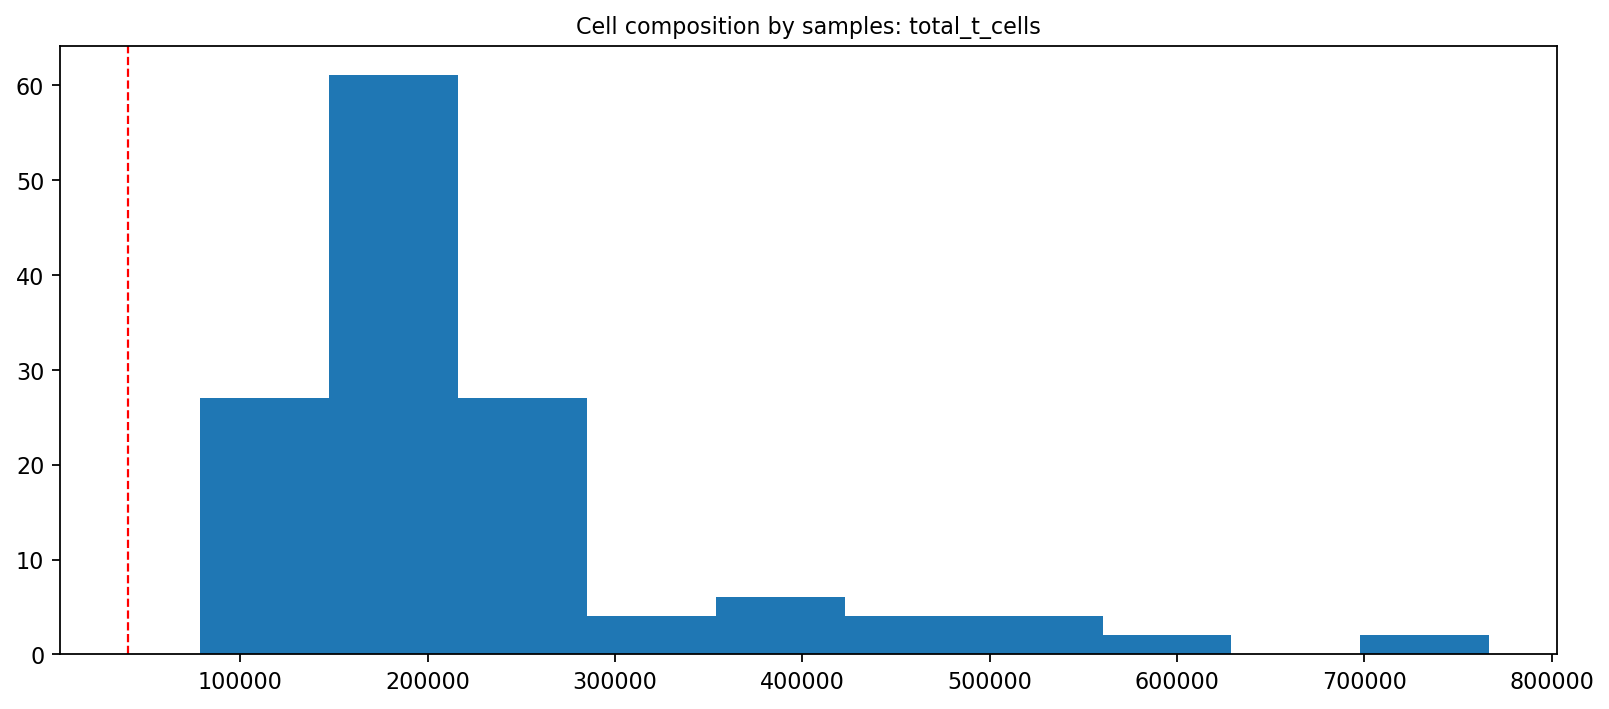

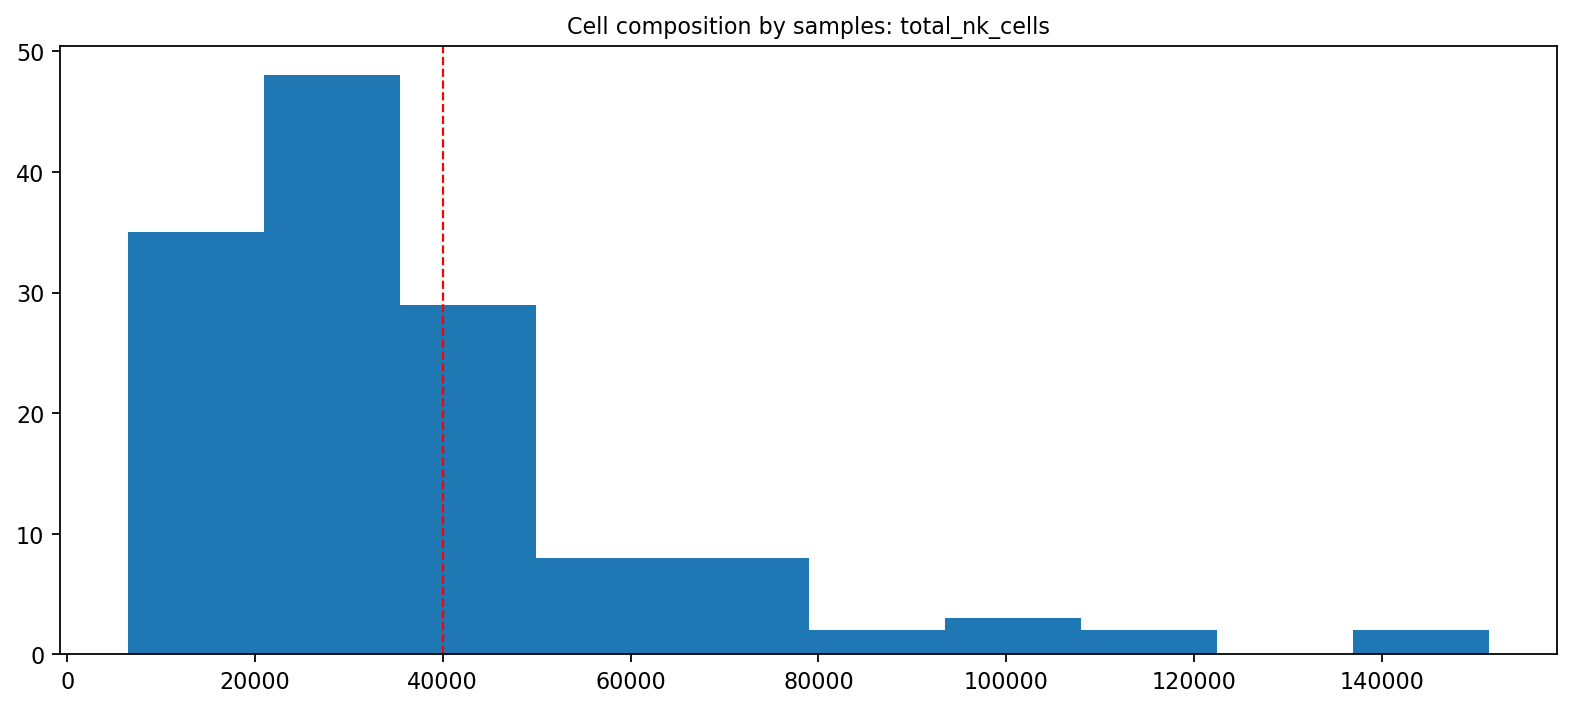

In [146]:
for ct in cell_types:
    plt.figure(figsize=(12, 5))
    plt.title("Cell composition by samples: " + ct)
    plt.hist(celltype_counts[[ct]])
    plt.axvline(40000, color='red', linestyle='dashed', linewidth=1)

### Conditional cell type subsets

In [143]:
adata_downsampled = subsample_adata_by_group(adata_sub_celltype, target_cells = 40000,cluster_key= ["sample_id", "l1_labels"] )

/tmp/ipykernel_34517/1395346938.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = anndata_obj.obs.groupby(cluster_key)


In [144]:
celltype_counts_downsample =pd.crosstab(adata_downsampled.obs['sample_id'], adata_downsampled.obs["l1_labels"],margins=True)

l1_labels   total_nk_cells  total_t_cells      All
sample_id                                         
PB00055-02           17540          40000    57540
PB00056-02           38902          40000    78902
PB00057-02           21568          40000    61568
PB00058-03           20665          40000    60665
PB00060-03           26300          40000    66300
...                    ...            ...      ...
PB04906-00           40000          40000    80000
PB04924-00           22233          40000    62233
PB04933-00           26766          40000    66766
PB04937-00           40000          40000    80000
All                4026789        5480000  9506789

[138 rows x 3 columns]


In [145]:
celltype_counts_downsample.reset_index().rename_axis(None, axis=1)

,sample_id,total_nk_cells,total_t_cells,All
0,PB00055-02,17540,40000,57540
1,PB00056-02,38902,40000,78902
2,PB00057-02,21568,40000,61568
3,PB00058-03,20665,40000,60665
4,PB00060-03,26300,40000,66300
...,...,...,...,...
133,PB04906-00,40000,40000,80000
134,PB04924-00,22233,40000,62233
135,PB04933-00,26766,40000,66766
136,PB04937-00,40000,40000,80000


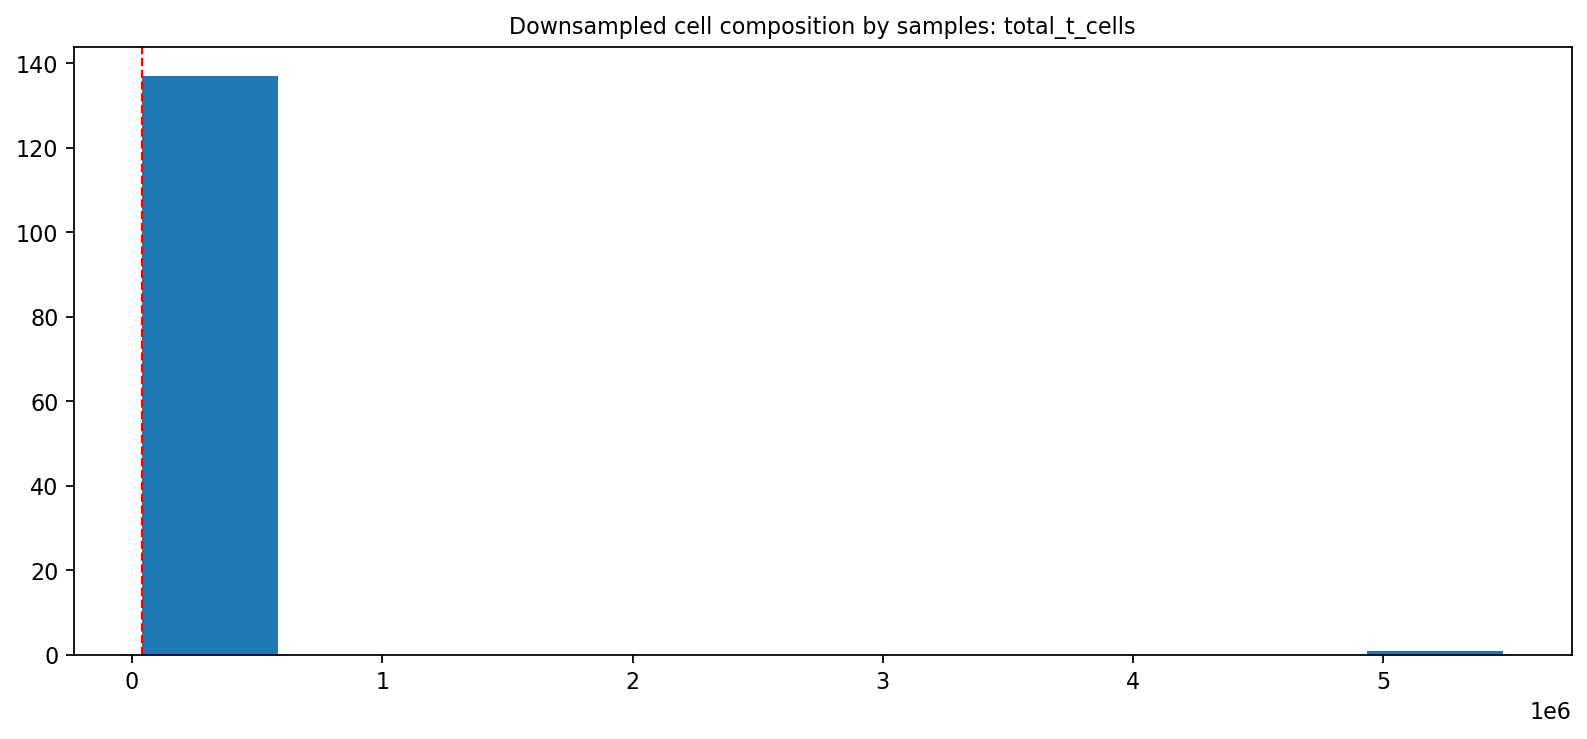

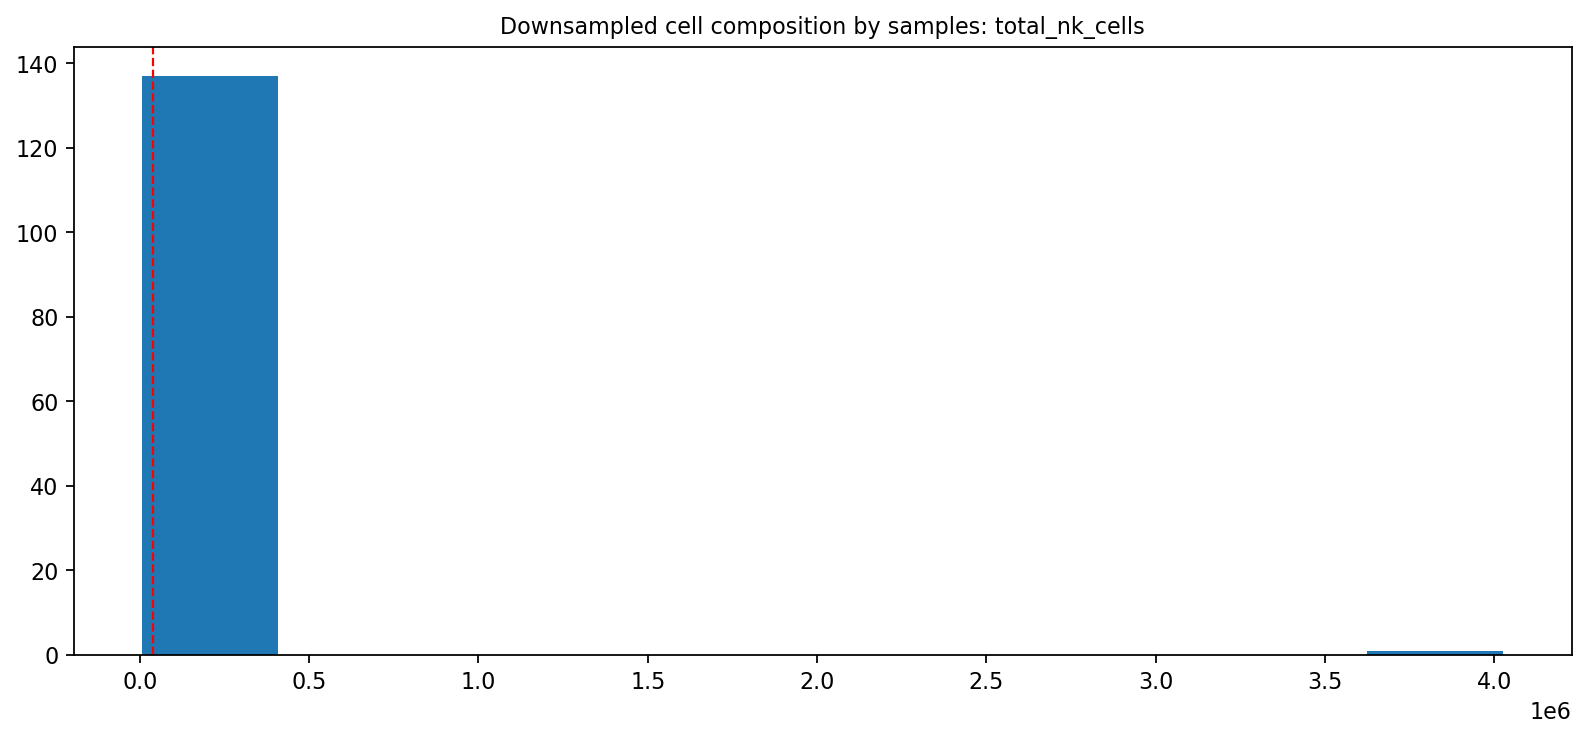

In [149]:
for ct in cell_types:
    plt.figure(figsize=(12, 5))
    plt.title("Downsampled cell composition by samples: " + ct)
    plt.hist(celltype_counts_downsample[[ct]])
    plt.axvline(40000, color='red', linestyle='dashed', linewidth=1)

In [179]:
celltype_counts_downsample = celltype_counts_downsample.add_prefix("downsample_")

In [151]:
adata_downsampled_celltypes = subset_anndata_by_cell_types(adata_downsampled,cell_types)

In [152]:
adata_downsampled_celltypes

{'total_t_cells': AnnData object with n_obs × n_vars = 5480000 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023',
 'total_nk_cells': AnnData object with n_obs × n_vars = 4026789 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'}

In [190]:
filenames = [output_path + "adata_preprocess_unscaled_downsmpl_celltypes_" + cell_type + "_" + panel + ".h5ad" for cell_type in cell_types]

In [200]:
### save annada from list

for anndata_obj, filename in zip(adata_downsampled_celltypes, filenames):
    print(adata_downsampled_celltypes[anndata_obj])
    adata_downsampled_celltypes[anndata_obj].write_h5ad(filename)

AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
AnnData object with n_obs × n_vars = 4026789 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'


In [210]:
file_tups = list(zip(filenames, cell_types))

In [211]:
### check anndata after exporting

adata_downsampled_celltypes = read_anndata_files(file_tups)
adata_downsampled_celltypes

{'total_t_cells': AnnData object with n_obs × n_vars = 5480000 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023',
 'total_nk_cells': AnnData object with n_obs × n_vars = 4026789 × 25
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'}

## Cell Frequency Tables

In [177]:
cellcount_sampleselect.reset_index(inplace=True)

In [180]:
celltype_counts_downsample.reset_index(inplace=True)

In [182]:
### merge total counts (after sample selection) to 
cellcounts_df = pd.merge(cellcount_sampleselect, celltype_counts_downsample)

In [186]:
cellcounts_df.to_csv(output_path + "counts_freq_celltypes_sample_select_" + panel + ".csv")